In [1]:
from multiprocessing import Pool

%matplotlib inline
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from  tqdm import tqdm
import plotly.graph_objects as go

import contextlib


from triqs.gf import Gf, MeshImFreq, MeshReFreq
from triqs.gf import iOmega_n, Omega, Flat, inverse
from triqs.gf import Idx # Use Idx to access Gf at specific Index
from triqs.plot.mpl_interface import oplot,plt


@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally: 
        np.set_printoptions(**original)



In [16]:
import sys
sys.path.append("../../../QEView/src")
sys.path.append("../../src")

%load_ext autoreload
%autoreload 2

from qeview.qe_analyse_FM import qe_analyse_FM
import qeview.wannier_loader as wnldr 

from jmapper import Exchanges2D, NeighboursFinder2D 
import jmapper.functions as jmpf


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wannier hamiltonian

In [60]:
nkpt = 24 #number of kpoints in one direction

In [90]:
loader = wnldr.Wannier_loader_FM('./', 'FeCl3')

nwa  28
Rpts 403
we have 2D hamiltonian
nwa  28
Rpts 403
we have 2D hamiltonian


In [91]:
loader.get_dense_hk(nkpt=nkpt) #get dense hamiltonian
loader.save_hk_pickle('nkpt24') #save it to file

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:02<00:00, 197.14it/s]


In [92]:
loader.load_hk_pickle('nkpt24') #load it from file if exists
hks = np.transpose(loader.hks_spins, (3, 2, 0, 1))
hk_mn_up = hks[0] 
hk_mn_dn = hks[1] 
hk_mn_dn.shape

(576, 28, 28)

In [93]:
dSarea = 1.0/(nkpt**2) #area of one kpoint (in fractional coordinates)

# ADJUST THIS TO YOUR NEEDS
Delta = np.real(dSarea*np.sum(hk_mn_up - hk_mn_dn, axis=0 ))
Delta[:18, :18] = 0 # remove s and p orbitals (they are not relevant, not magnetic) 
Delta[18:, :18] = 0
Delta[:18, 18:] = 0



with printoptions(precision=2, suppress=True):
    #     print(Delta[i, i])
    print(Delta[18:, 18:]) #

assert np.allclose( np.linalg.norm(np.conj(Delta.T) - Delta), 0) #check if Delta is hermitian

[[-9.41 -0.    0.    0.    0.   -0.    0.    0.    0.   -0.  ]
 [-0.   -7.6   0.    1.18  0.   -0.   -0.   -0.   -0.01 -0.  ]
 [ 0.    0.   -7.6   0.   -1.18 -0.    0.   -0.   -0.   -0.  ]
 [ 0.    1.18  0.   -8.45 -0.   -0.    0.01  0.    0.   -0.  ]
 [ 0.    0.   -1.18 -0.   -8.45  0.    0.    0.   -0.    0.  ]
 [-0.   -0.   -0.   -0.    0.    9.41  0.   -0.   -0.   -0.  ]
 [ 0.   -0.    0.    0.01  0.    0.    7.6  -0.   -1.18 -0.  ]
 [ 0.   -0.   -0.    0.    0.   -0.   -0.    7.6  -0.    1.18]
 [ 0.   -0.01 -0.    0.   -0.   -0.   -1.18 -0.    8.45 -0.  ]
 [-0.   -0.   -0.   -0.    0.   -0.   -0.    1.18  0.    8.45]]


In [94]:
# We choose the block of Delta that correspond to different atoms
# in this case we have only one atom, so we take the whole Delta 
# normally it would be block matrix with number of blocks equal to number of atoms
dDelta = Delta[18:, 18:]
DeltaBlock = np.array([
    [dDelta[:5, :5], dDelta[:5, 5:]],
    [dDelta[5:, :5], dDelta[5:, 5:]]
])
DeltaBlock.shape


(2, 2, 5, 5)

In [95]:

with printoptions(precision=2, suppress=True):
    #     print(Delta[i, i])
    print(dDelta[:5, :5]) #


[[-9.41 -0.    0.    0.    0.  ]
 [-0.   -7.6   0.    1.18  0.  ]
 [ 0.    0.   -7.6   0.   -1.18]
 [ 0.    1.18  0.   -8.45 -0.  ]
 [ 0.    0.   -1.18 -0.   -8.45]]


In [96]:
# get basic information about the system
calc = qe_analyse_FM('./', 'FeCl3')

efermi -5.90
Unit Cell Volume:   619.7840  (Ang^3)
alat 6.1000
Reciprocal-Space Vectors cart (Ang^-1)
[[ 1.0300303041  0.5946882733 -0.          ]
 [ 0.            1.1893765467  0.          ]
 [ 0.           -0.            0.3266855085]]
Reciprocal-Space Vectors cart (2 pi / alat)
[[ 1.            0.5773502692 -0.          ]
 [ 0.            1.1547005384  0.          ]
 [ 0.           -0.            0.3171610653]]
Real-Space Vectors cart (Ang)
[[ 6.1000004391  0.            0.          ]
 [-3.0500002195  5.2827553433  0.          ]
 [ 0.            0.           19.2331313844]]
Real-Space Vectors cart (alat)
[[ 1.            0.            0.          ]
 [-0.5           0.8660254038  0.          ]
 [ 0.            0.            3.1529721311]]


 positions cart (alat)
['Fe1', 'Fe2', 'Cl', 'Cl', 'Cl', 'Cl', 'Cl', 'Cl']
[[ 0.            0.            1.0509518237]
 [ 0.            0.5773502692  1.051029597 ]
 [ 0.186834      0.8312065638  0.8405907781]
 [-0.313263      0.6122251122  0.84059

# Green's functions

In [97]:
nwa = 28 # number of wannier functions, not restricted to d orbitals

In [98]:
beta = 18
n_iw = 120
eF = calc.efermi # not precise from last nscf calculation

iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=n_iw)
Giws_up = [Gf(mesh=iw_mesh, target_shape=[nwa, nwa]) for kpt in range(len(hk_mn_up))]
Giws_dn = [Gf(mesh=iw_mesh, target_shape=[nwa, nwa]) for kpt in range(len(hk_mn_dn))]

for kpt in tqdm(range(len(hk_mn_up))):
    Giws_up[kpt] << inverse(iOmega_n  + eF*np.eye(nwa) - hk_mn_up[kpt])
    Giws_up[kpt] = np.array(Giws_up[kpt].data, dtype=np.complex64)
Giws_up = np.array(Giws_up, dtype=np.complex64)

for kpt in tqdm(range(len(hk_mn_dn))):
    Giws_dn[kpt] << inverse(iOmega_n  + eF*np.eye(nwa) - hk_mn_dn[kpt])
    Giws_dn[kpt] = np.array(Giws_dn[kpt].data, dtype=np.complex64)
Giws_dn = np.array(Giws_dn, dtype=np.complex64)


100%|██████████| 576/576 [00:09<00:00, 62.49it/s]


In [99]:
# now we restrict the Green's function to the d orbitals
# thisis normally also block matrix with number of blocks equal to number of atoms as for Delta
# dGiws_up = Giws_up[:, :, :, :]
dGiws_up = Giws_up[:, :, 18:, 18:]
Giws_upBlock = np.array([
    [dGiws_up[:, :, :5, :5], dGiws_up[:, :, :5, 5:]],
    [dGiws_up[:, :, 5:, :5], dGiws_up[:, :, 5:, 5:]]
])

dGiws_dn = Giws_dn[:, :, 18:, 18:]
Giws_dnBlock = np.array([
    [dGiws_dn[:, :, :5, :5], dGiws_dn[:, :, :5, 5:]],
    [dGiws_dn[:, :, 5:, :5], dGiws_dn[:, :, 5:, 5:]]
])
print(Giws_upBlock.shape)

# (num_sites, num_sites, nkpt, num_iw, nwa, nwa)


(2, 2, 576, 240, 5, 5)


In [100]:
# now we can calculate the exchange interactions
exch = Exchanges2D(Giws_upBlock, Giws_dnBlock, DeltaBlock, beta, nkpt_dir=nkpt, S=4.0283/2.)
# insert your actual spin values 

(2, 2, 6000, 576)
J00= 3914.54027+0.00000j meV
J11= 3914.67617+0.00000j meV


# J(R)

In [101]:
nfinder = NeighboursFinder2D(calc) # util class to find neighbours in the system

In [113]:
neibs00 = nfinder.find(0, 0, num_orders=5) # find neighbours of atom 0, 0 with max order (distance) 5

JR_00 = []
for item in neibs00.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    for neib in item[1]:
        # print(neib)
        val = exch.calc_J(np.array(neib), 0, 0)
        tmp.append(val)
    tmp = np.mean(tmp)
    JR_00.append(tmp)

JR_00 = np.array(JR_00)


Fe1 Fe1
(0.0, [[0, 0]])
J00= 3914.54027+0.00000j meV
(6.1, [[-1, -1], [-1, 0], [0, -1], [0, 1], [1, 0], [1, 1]])
J00= -0.35022-0.00000j meV
J00= -0.34939-0.00000j meV
J00= -0.35021+0.00000j meV
J00= -0.35021-0.00000j meV
J00= -0.34939+0.00000j meV
J00= -0.35022+0.00000j meV
(10.57, [[-2, -1], [-1, -2], [-1, 1], [1, -1], [1, 2], [2, 1]])
J00= -0.00299+0.00000j meV
J00= -0.00299+0.00000j meV
J00= -0.00299+0.00000j meV
J00= -0.00299-0.00000j meV
J00= -0.00299-0.00000j meV
J00= -0.00299-0.00000j meV
(12.2, [[-2, -2], [-2, 0], [0, -2], [0, 2], [2, 0], [2, 2]])
J00= -0.00074-0.00000j meV
J00= -0.00074-0.00000j meV
J00= -0.00074+0.00000j meV
J00= -0.00074-0.00000j meV
J00= -0.00074+0.00000j meV
J00= -0.00074+0.00000j meV
(16.14, [[-3, -2], [-3, -1], [-2, -3], [-2, 1], [-1, -3], [-1, 2], [1, -2], [1, 3], [2, -1], [2, 3], [3, 1], [3, 2]])
J00= 0.00000-0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000+0.00000j meV
J0

In [114]:
neibs01 = nfinder.find(0, 1, num_orders=5) # find neighbours of atom 0, 0 with max order (distance) 5

JR_01 = []
for item in neibs01.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    for neib in item[1]:
        # print(neib)
        val = exch.calc_J(np.array(neib), 0, 1)
        tmp.append(val)
    tmp = np.mean(tmp)
    JR_01.append(tmp)

JR_01 = np.array(JR_01)


Fe1 Fe2
(3.52, [[0, 0], [0, 1], [1, 1]])
J01= 5.06562+0.00000j meV
J01= 5.08117-0.00000j meV
J01= 5.08118-0.00000j meV
(7.04, [[-1, 0], [1, 0], [1, 2]])
J01= 0.03737-0.00000j meV
J01= 0.03738-0.00000j meV
J01= 0.03720-0.00000j meV
(9.32, [[-1, -1], [-1, 1], [0, -1], [0, 2], [2, 1], [2, 2]])
J01= 0.00909+0.00000j meV
J01= 0.00906-0.00000j meV
J01= 0.00909+0.00000j meV
J01= 0.00913+0.00000j meV
J01= 0.00906+0.00000j meV
J01= 0.00913+0.00000j meV
(12.7, [[-2, -1], [-2, 0], [1, -1], [1, 3], [2, 0], [2, 3]])
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006+0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
(14.09, [[-1, -2], [-1, 2], [3, 2]])
J01= 0.00036+0.00000j meV
J01= 0.00036+0.00000j meV
J01= 0.00036+0.00000j meV


In [115]:
neibs10 = nfinder.find(1, 0, num_orders=5)
JR_10 = []
for item in neibs10.items():
    print(item)
    for neib in item[1]:
        # print(neib)
        exch.calc_J(np.array(neib), 1, 0)

Fe2 Fe1
(3.52, [[-1, -1], [0, -1], [0, 0]])
J10= 5.08118+0.00000j meV
J10= 5.08117+0.00000j meV
J10= 5.06562-0.00000j meV
(7.04, [[-1, -2], [-1, 0], [1, 0]])
J10= 0.03720+0.00000j meV
J10= 0.03738+0.00000j meV
J10= 0.03737+0.00000j meV
(9.32, [[-2, -2], [-2, -1], [0, -2], [0, 1], [1, -1], [1, 1]])
J10= 0.00913+0.00000j meV
J10= 0.00906-0.00000j meV
J10= 0.00913-0.00000j meV
J10= 0.00909-0.00000j meV
J10= 0.00906+0.00000j meV
J10= 0.00909-0.00000j meV
(12.7, [[-2, -3], [-2, 0], [-1, -3], [-1, 1], [2, 0], [2, 1]])
J10= -0.00006+0.00000j meV
J10= -0.00006+0.00000j meV
J10= -0.00006-0.00000j meV
J10= -0.00006+0.00000j meV
J10= -0.00006+0.00000j meV
J10= -0.00006+0.00000j meV
(14.09, [[-3, -2], [1, -2], [1, 2]])
J10= 0.00036-0.00000j meV
J10= 0.00036-0.00000j meV
J10= 0.00036+0.00000j meV


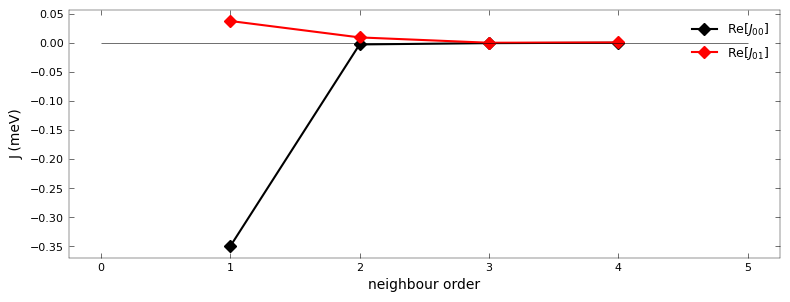

In [116]:
fig, dd = plt.subplots()

dd.plot(np.arange(1, len(JR_00), 1), 
        np.real(JR_00[1:]*1000),  color='black', 
            alpha=1, marker="D",  label=r'Re[$J_{00}$]')

dd.plot(np.arange(1, len(JR_01), 1), 
        np.real(JR_01[1:]*1000),  color='red', 
            alpha=1, marker="D",  label=r'Re[$J_{01}$]')

dd.set_ylabel('J (meV)')  # Add an x-label to the axes.
dd.set_xlabel('neighbour order')  # Add a y-label to the axes.
dd.legend(prop={'size': 9}, frameon=False)  # Add a legend.

dd.xaxis.set_major_locator(MultipleLocator(1))
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")
dd.hlines(0, xmin=0, xmax=len(JR_00), colors='black', linewidth=0.4)


plt.rcParams['axes.linewidth'] = 0.3
fig.set_figwidth(8)    
fig.set_figheight(5/1.6)    
fig.tight_layout()
# plt.savefig('./2pub/pics/J_r_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()

# J(q)

In [120]:
# J(q) on the dense mesh [0, 1]^2 in fractional coordinates
Jqs = exch.getJqpath(0, 0, exch.kMesh_int)

# should be zero for interactions between the same atom
assert np.allclose(1000*np.sum(Jqs)*exch.dSarea, 0)


  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [01:18<00:00,  7.36it/s]


In [121]:
# rescale to 4 BZ for symmetry
A = np.real(Jqs).reshape(nkpt,nkpt).T
JBZ = np.block([[A, A], 
              [A, A]])

In [132]:
kpoints_2BZ = np.mgrid[-1:1:1/nkpt, -1:1:1/nkpt].reshape(2,-1).T


z= np.real(JBZ.reshape( -1))

jmpf.plot_Jq_1BZ(calc, kpoints_2BZ, z)

## J(R) from Fourier of J(q)

In [112]:
# J(q) on the dense mesh [0, 1]^2 in fractional coordinates
Jqs01 = exch.getJqpath(0, 1, exch.kMesh_int)
Jqs00 = exch.getJqpath(0, 0, exch.kMesh_int)


  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [01:17<00:00,  7.45it/s]


In [125]:
JR_00 = []
for item in neibs00.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    jrs =  exch.getJRpath(item[1], 0, 0, verb=True, Jqs_dense=Jqs00)
    JR_00.append(np.mean(jrs))
JR_00 = np.array(JR_00)

(0.0, [[0, 0]])


100%|██████████| 1/1 [00:00<00:00, 230.33it/s]


J00= 0.00000-0.00000j meV
(6.1, [[-1, -1], [-1, 0], [0, -1], [0, 1], [1, 0], [1, 1]])


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 252.93it/s]


J00= -0.35022-0.00000j meV
J00= -0.34939+0.00000j meV
J00= -0.35021-0.00000j meV
J00= -0.35021+0.00000j meV
J00= -0.34939-0.00000j meV
J00= -0.35022+0.00000j meV
(10.57, [[-2, -1], [-1, -2], [-1, 1], [1, -1], [1, 2], [2, 1]])


100%|██████████| 6/6 [00:00<00:00, 215.04it/s]


J00= -0.00299+0.00000j meV
J00= -0.00299+0.00000j meV
J00= -0.00299-0.00000j meV
J00= -0.00299+0.00000j meV
J00= -0.00299-0.00000j meV
J00= -0.00299-0.00000j meV
(12.2, [[-2, -2], [-2, 0], [0, -2], [0, 2], [2, 0], [2, 2]])


100%|██████████| 6/6 [00:00<00:00, 215.07it/s]


J00= -0.00074-0.00000j meV
J00= -0.00074-0.00000j meV
J00= -0.00074-0.00000j meV
J00= -0.00074+0.00000j meV
J00= -0.00074+0.00000j meV
J00= -0.00074+0.00000j meV
(16.14, [[-3, -2], [-3, -1], [-2, -3], [-2, 1], [-1, -3], [-1, 2], [1, -2], [1, 3], [2, -1], [2, 3], [3, 1], [3, 2]])


100%|██████████| 12/12 [00:00<00:00, 261.33it/s]

J00= 0.00000+0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000-0.00000j meV
J00= 0.00000+0.00000j meV
J00= 0.00000-0.00000j meV


In [124]:
JR_01 = []
for item in neibs01.items():
    print(item) # dist (\AA), neibs in crystal coordinates
    tmp = []
    jrs =  exch.getJRpath(item[1], 0, 1, verb=True, Jqs_dense=Jqs01)
    JR_01.append(np.mean(jrs))
JR_01 = np.array(JR_01)

(3.52, [[0, 0], [0, 1], [1, 1]])


100%|██████████| 3/3 [00:00<00:00, 234.22it/s]


J01= 5.06562+0.00000j meV
J01= 5.08117+0.00000j meV
J01= 5.08118+0.00000j meV
(7.04, [[-1, 0], [1, 0], [1, 2]])


100%|██████████| 3/3 [00:00<00:00, 246.38it/s]

J01= 0.03737-0.00000j meV
J01= 0.03738-0.00000j meV
J01= 0.03720-0.00000j meV
(9.32, [[-1, -1], [-1, 1], [0, -1], [0, 2], [2, 1], [2, 2]])


100%|██████████| 6/6 [00:00<00:00, 260.24it/s]


J01= 0.00909+0.00000j meV
J01= 0.00906+0.00000j meV
J01= 0.00909+0.00000j meV
J01= 0.00913-0.00000j meV
J01= 0.00906+0.00000j meV
J01= 0.00913+0.00000j meV
(12.7, [[-2, -1], [-2, 0], [1, -1], [1, 3], [2, 0], [2, 3]])


100%|██████████| 6/6 [00:00<00:00, 263.16it/s]


J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
J01= -0.00006-0.00000j meV
(14.09, [[-1, -2], [-1, 2], [3, 2]])


100%|██████████| 3/3 [00:00<00:00, 259.67it/s]

J01= 0.00036+0.00000j meV
J01= 0.00036-0.00000j meV
J01= 0.00036+0.00000j meV


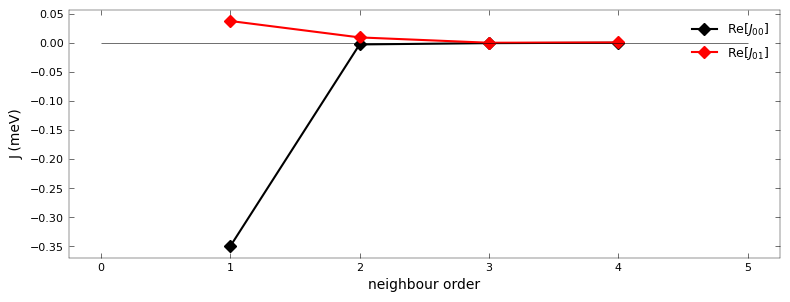

In [126]:
fig, dd = plt.subplots()

dd.plot(np.arange(1, len(JR_00), 1), 
        np.real(JR_00[1:]*1000),  color='black', 
            alpha=1, marker="D",  label=r'Re[$J_{00}$]')

dd.plot(np.arange(1, len(JR_01), 1), 
        np.real(JR_01[1:]*1000),  color='red', 
            alpha=1, marker="D",  label=r'Re[$J_{01}$]')

dd.set_ylabel('J (meV)')  # Add an x-label to the axes.
dd.set_xlabel('neighbour order')  # Add a y-label to the axes.
dd.legend(prop={'size': 9}, frameon=False)  # Add a legend.

dd.xaxis.set_major_locator(MultipleLocator(1))
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")
dd.hlines(0, xmin=0, xmax=len(JR_00), colors='black', linewidth=0.4)


plt.rcParams['axes.linewidth'] = 0.3
fig.set_figwidth(8)    
fig.set_figheight(5/1.6)    
fig.tight_layout()
# plt.savefig('./2pub/pics/J_r_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()

# J(q) path

In [79]:
# get the kpath for plotting (needed in integer coordinates)
kpath, kpath_draw = calc.get_integer_kpath(N_points_direction=nkpt, 
                                           num_points_betweens=[10, 4, 9], 
                                           filename=f'kpath_integer_nkdir={nkpt}.dat',
                                           saveQ=True)


G 0 0 0 	 0.00000000 
. 0 1 0 	 0.05773503 
. 0 2 0 	 0.11547005 
. 0 3 0 	 0.17320508 
. 0 4 0 	 0.23094011 
. 0 6 0 	 0.28867513 
. 0 7 0 	 0.34641016 
. 0 8 0 	 0.40414519 
. 0 9 0 	 0.46188022 
. 0 10 0 	 0.51961524 
M 0 12 0 	 0.57735027 
. -1 13 0 	 0.66068360 
. -3 14 0 	 0.74401694 
. -5 15 0 	 0.82735027 
K -7 16 0 	 0.91068360 
. -7 14 0 	 0.98475768 
. -6 12 0 	 1.05883175 
. -5 10 0 	 1.13290582 
. -4 8 0 	 1.20697990 
. -3 7 0 	 1.28105397 
. -2 5 0 	 1.35512805 
. -1 3 0 	 1.42920212 
. 0 1 0 	 1.50327620 
G 0 0 0 	 1.57735027 



In [ ]:
#changed to proper path
# M  0 12 0 	 0.57736847 
# . -2 13 0  	 0.66070443 
# . -4 14 0  	 0.74404039 
# . -6 15 0  	 0.82737635 
# K -8 16 0  	 0.91071231 

In [127]:

kpath = []
kpath_draw = []
with open(f'./kpaths/kpath_integer_nkdir={nkpt}.dat') as f:
        # f.readline()
        for line in f:
            hr_string = line.split()
            kpath.append(np.array([
                    int(hr_string[1]), int(hr_string[2]), int(hr_string[3])
                ]))
            kpath_draw.append(float(hr_string[4]))
kpath = np.array(kpath)                
# kpath

In [128]:
Jqs00 = exch.getJqpath(0, 0, kpath[:, :2])
Jqs01 = exch.getJqpath(0, 1, kpath[:, :2])


  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:03<00:00,  7.39it/s]


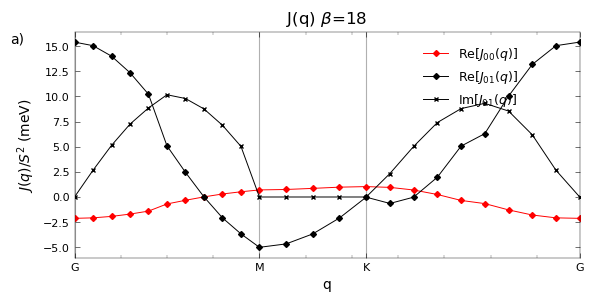

In [129]:
fig, (dd) = plt.subplots()#1, 2, gridspec_kw={'width_ratios': [1.5, 1]}

normal_ticks = calc.HighSymPointsDists
label_ticks = calc.HighSymPointsNames

dd.plot(kpath_draw, Jqs00*1000,  color='red', linewidth=0.7,
            alpha=1, marker="D",  markersize=3.0,  label=r"Re[$J_{00} (q)$]")

dd.plot(kpath_draw, np.real(Jqs01)*1000,  color='black', linewidth=0.7,
            alpha=1, marker="D",  markersize=3.0,  label=r"Re[$J_{01} (q)$]")

dd.plot(kpath_draw, np.imag(Jqs01)*1000,  color='black', linewidth=0.7,
            alpha=1, marker="x",  markersize=3.0,  label=r"Im[$J_{01} (q)$]")


dd.set_ylabel(r'$J(q)/S^2$ (meV)')  # Add an x-label to the axes.
dd.set_xlabel('q')  # Add a y-label to the axes.
dd.set_title(rf'J(q) $\beta$={beta:.0f}')
dd.legend(prop={'size': 9}, frameon=False, loc='upper right', bbox_to_anchor=(0.9, 0.99))  # Add a legend.
# locator = AutoMinorLocator()
# dd.yaxis.set_minor_locator(MultipleLocator(0.05))

dd.set_xticks(normal_ticks, label_ticks)
dd.grid(axis='x')
dd.xaxis.set_minor_locator(AutoMinorLocator())
dd.tick_params(top=True, right=True, which='minor',length=2, width=0.2, direction="in")
dd.tick_params(top=True, right=True, which='major',length=3.5, width=0.4, labelsize=8, direction="in")

dd.set_xlim(normal_ticks[0], normal_ticks[-1])
# dd.set_ylim(-0.3, 0.2)
dd.text(-0.1, 1.0, 'a)', transform=dd.transAxes,
        fontsize=10, fontweight='normal', va='top', ha='right')



plt.rcParams['axes.linewidth'] = 0.3
width = 5
fig.set_figwidth(6)    
fig.set_figheight(5/1.6)    
fig.tight_layout()
# plt.savefig('./2pub/pics/Jq_beta_10.eps', 
#             format='eps', dpi=200, bbox_inches='tight')

plt.show()